In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import shutil
import os
import csv
%matplotlib inline

In [2]:
TRAIN_FOLDER = './data/train'
VAL_FOLDER = './data/val'
TEST_FOLDER = './data/test'
IMAGE_SIZE = 224

### 1. generate object images with perspective

In [3]:
object_img = cv2.imread('source-data/dt.png', cv2.IMREAD_UNCHANGED)
object_img = cv2.resize(object_img, (IMAGE_SIZE, IMAGE_SIZE))

rows,cols,ch = object_img.shape

SMALL_RECT_LEFT = rows*2/6
SMALL_RECT_RIGHT = rows*4/6
SMALL_RECT_TOP = cols*2/6
SMALL_RECT_BOTTOM = cols*4/6

In [4]:
def get_image(path, num_image=100):
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)

    corners = []

    i = 0
    while i < num_image:
        # change color
        hsv_color = cv2.cvtColor(object_img, cv2.COLOR_BGR2HSV)
#         rand = np.random.randint(0, 180)
#         hsv_color[:, :, 0] += rand
        hsv_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)
        
        # random all points
        left = np.random.randint(0, SMALL_RECT_LEFT, size=2)
        right = np.random.randint(SMALL_RECT_RIGHT, cols, size=2)
        top = np.random.randint(0, SMALL_RECT_TOP, size=2)
        bottom = np.random.randint(SMALL_RECT_BOTTOM, rows, size=2)

        # re-random if bottom-left point is over the diagonal
        # because image start from top-left so the y-axis should be opposite
        top_right_to_bottom_left_slope = -(top[1]-bottom[0])/(right[0]-left[1])
        bottom_right_to_bottom_left_slope = -(bottom[1]-bottom[0])/(right[1]-left[1])
        if bottom_right_to_bottom_left_slope > top_right_to_bottom_left_slope:
            print('re-random at ', path, i)
            continue

        # declare points
        pts1 = np.float32([[0,0],[cols,0],[0,rows],[cols, rows]])

        top_left = [left[0], top[0]]
        right_top = [right[0], top[1]]
        left_bottom = [left[1], bottom[0]]
        right_bottom = [right[1], bottom[1]]
        pts2 = np.float32([top_left, right_top, left_bottom, right_bottom])


        # transform
        perspectiveTransform = cv2.getPerspectiveTransform(pts1,pts2)
        wrapPerspective = cv2.warpPerspective(hsv_color, perspectiveTransform, (cols, rows))
        
        pathlib.Path(path).mkdir(parents=True, exist_ok=True)
        cv2.imwrite(f'{path}/object_image{i}.png',wrapPerspective)

        points = np.concatenate((top_left, right_top, left_bottom, right_bottom))
        corners.append(points)

        i+=1
    file = open(f'{path}/corners.csv', 'w')
    with file:
        writer = csv.writer(file)
        writer.writerows(corners)

In [5]:
get_image(TRAIN_FOLDER, 1024)
get_image(VAL_FOLDER, 128)
get_image(TEST_FOLDER, 128)

### 2. Train

In [7]:
import csv
import math

import cv2
from keras.applications.mobilenet import MobileNet, _depthwise_conv_block
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import *
from keras.utils import Sequence

ALPHA = 0.25
# IMAGE_SIZE = 128 move to top

EPOCHS = 5000
PATIENCE = 100


class DataSequence(Sequence):

    def __load_images(self, dataset):
        out = []
        for file_name in dataset:
            im = cv2.resize(cv2.imread(file_name), (self.image_size, self.image_size))
            out.append(im)

        return np.array(out)

    def __init__(self, csv_file, image_path, image_size, batch_size=32, feature_scaling=False):
        self.csv_file = csv_file
        with open(self.csv_file, "r") as file:
            reader = csv.reader(file, delimiter=",")
            arr = list(reader)

        self.y = np.zeros((len(arr), 8))
        self.x = []
        self.image_size = image_size

        # for index, (path, class_id, width, height, x0, y0, x1, y1) in enumerate(arr):
        for index, coner_points in enumerate(arr):
            self.y[index] = np.array(coner_points)
            self.x.append(f'{image_path}/object_image{index}.png')

        self.batch_size = batch_size
        self.feature_scaling = feature_scaling
        if self.feature_scaling:
            dataset = self.__load_images(self.x)
            broadcast_shape = [1, 1, 1]
            broadcast_shape[2] = dataset.shape[3]

            self.mean = np.mean(dataset, axis=(0, 1, 2))
            self.mean = np.reshape(self.mean, broadcast_shape)
            self.std = np.std(dataset, axis=(0, 1, 2))
            self.std = np.reshape(self.std, broadcast_shape) + K.epsilon()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = self.__load_images(batch_x).astype('float32')
        if self.feature_scaling:
            images -= self.mean
            images /= self.std

        return images, batch_y


def create_model(size, alpha):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(size, size, 3)))
#     model.add(Dropout(0.25))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    print(model.output_shape)
    model.add(MaxPooling2D((27, 27)))
    model.add(Conv2D(8, (1, 1), activation='relu'))
    print(model.output_shape)
    model.add(Reshape((8,)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(8))
    return model

def create_model2(size, alpha):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(size, size, 3)))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(8))
    return model

def create_mobile_net_model(size, alpha):
    model_net = MobileNet(input_shape=(size, size, 3), include_top=False, alpha=alpha)
    x = _depthwise_conv_block(model_net.layers[-1].output, 1024, alpha, 1, block_id=14)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Conv2D(8, kernel_size=(1, 1), padding="same")(x)
    x = Reshape((8,))(x)
    
#     if I use flatten it will cause overfitting, I don't know why
#     x = Flatten()(x)
#     x = Dense(8)(x)

    return Model(inputs=model_net.input, outputs=x)


def train(model, epochs, image_size):
    train_datagen = DataSequence("./data/train/corners.csv", "./data/train", image_size)
    validation_datagen = DataSequence("./data/val/corners.csv", "./data/val", image_size)

    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
    checkpoint = ModelCheckpoint("model-{val_acc:.2f}.h5", monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="auto", period=1)
    stop = EarlyStopping(monitor="val_acc", patience=PATIENCE, mode="auto")

    model.fit_generator(train_datagen, steps_per_epoch=1028, epochs=epochs, validation_data=validation_datagen,
                        validation_steps=22, callbacks=[checkpoint, stop])


In [ ]:
def main():
    model = create_mobile_net_model(IMAGE_SIZE, ALPHA)
#     model = create_model2(IMAGE_SIZE, ALPHA)
    train(model, EPOCHS, IMAGE_SIZE)


if __name__ == "__main__":
    main()


Epoch 1/5000
1028/1028 [==============================] - 184s 179ms/step - loss: 971.8711 - acc: 0.6832 - val_loss: 23.0739 - val_acc: 0.9162

Epoch 00001: val_acc improved from -inf to 0.91619, saving model to model-0.92.h5
Epoch 2/5000
1028/1028 [==============================] - 178s 173ms/step - loss: 4.6905 - acc: 0.9493 - val_loss: 11.4937 - val_acc: 0.9119

Epoch 00002: val_acc did not improve from 0.91619
Epoch 3/5000
  74/1028 [=>............................] - ETA: 2:44 - loss: 2.1888 - acc: 0.9662

### 3. Validation/ gen prediction lines

In [56]:
import shutil
import glob

OUTPUT_TEST_PATH = './data/output_test'
if os.path.isdir(OUTPUT_TEST_PATH):
    shutil.rmtree(OUTPUT_TEST_PATH)
model = create_model(IMAGE_SIZE, ALPHA)
model.load_weights('model-0.96.h5')

image_paths = sorted(glob.glob('{}/*png'.format(TEST_FOLDER)))
for i, image_path in enumerate(image_paths):
    image = cv2.resize(cv2.imread(image_path), (IMAGE_SIZE, IMAGE_SIZE))
    points = model.predict(x=np.array([image]))[0].astype(int)
    points = np.array([[points[0], points[1]], 
                       [points[2], points[3]], 
                       [points[6], points[7]], 
                       [points[4], points[5]]])
    cv2.polylines(image, [points], True, (255,255,255))
    pathlib.Path(OUTPUT_TEST_PATH).mkdir(parents=True, exist_ok=True)
    cv2.imwrite(f'{OUTPUT_TEST_PATH}/image{i}.png', image)

[[[103 255 153]
  [103 255 153]]

 [[103 255 153]
  [103 255 153]]]
[[[103 255 153]
  [103 255 153]]

 [[103 255 153]
  [103 255 153]]]
[[[103 255 153]
  [103 255 153]]

 [[103 255 153]
  [103 255 153]]]
[[[103 255 153]
  [103 255 153]]

 [[103 255 153]
  [103 255 153]]]


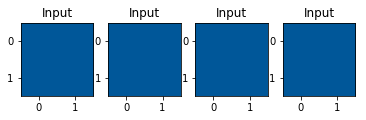

In [147]:
# img = np.array([[[255, 0, 0], [255, 0, 0] ],
#                 [[0, 255, 0], [0, 0, 255]]])
# img = img.astype(np.uint8)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

img = cv2.resize(cv2.imread('./data/test/object_image0.png'), (2,2))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

index = 141
def plot(img, h):
    global index
#     img[:, :, 2] += h
#     img[:, :, 1] = 10
#     img = np.where(img>180, img-180, img)
    print(img)
#     print('------')
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.subplot(index),plt.imshow(img),plt.title('Input')
    index += 1
    
plot(img.copy(), 0) # blue
plot(img.copy(), 60) # green
plot(img.copy(), 120) # red
plot(img.copy(), 180) # blue